In [61]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import joblib
import os 
import shutil
import pickle
from time import time

# Modelling

# 1 Preparation
Prepare both direction 1 and 2 csvs for modelling

Read in files for direction 1 and 2

In [46]:
df_dir_1 = pd.read_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/cleaned/feature_pairwise_cleaned_dir1.csv')
df_dir_2 = pd.read_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/cleaned/feature_pairwise_cleaned_dir2.csv')


Print some descriptors of the data

In [47]:
print("The shape of the direction 1 dataframe is:", df_dir_1.shape)
print("The shape of the direction 2 dataframe is:", df_dir_2.shape)


The shape of the direction 1 dataframe is: (937718, 11)
The shape of the direction 2 dataframe is: (933567, 10)


In [48]:
print("The datatypes in the direction 1 dataframe is:")
print(df_dir_1.dtypes)
print("The datatypes in the direction 2 dataframe is:")
print(df_dir_2.dtypes)


The datatypes in the direction 1 dataframe is:
LINEID              object
PLANNEDTIME_DEP    float64
HOUR                 int64
temp               float64
humidity             int64
wind_speed         float64
weather_id           int64
TRIPTIME           float64
WEEKDAY              int64
MONTH                int64
RUSHHOUR             int64
dtype: object
The datatypes in the direction 2 dataframe is:
LINEID              object
PLANNEDTIME_DEP    float64
HOUR                 int64
humidity             int64
wind_speed         float64
weather_id           int64
TRIPTIME           float64
WEEKDAY              int64
MONTH                int64
RUSHHOUR             int64
dtype: object


Check for null values

In [49]:
print("The number of null values in the direction 1 dataframe is: ",
      str(df_dir_1.isna().sum()))
print("The number of null values in the direction 2 dataframe is: ",
      str(df_dir_2.isna().sum()))


The number of null values in the direction 1 dataframe is:  LINEID             0
PLANNEDTIME_DEP    0
HOUR               0
temp               0
humidity           0
wind_speed         0
weather_id         0
TRIPTIME           0
WEEKDAY            0
MONTH              0
RUSHHOUR           0
dtype: int64
The number of null values in the direction 2 dataframe is:  LINEID             0
PLANNEDTIME_DEP    0
HOUR               0
humidity           0
wind_speed         0
weather_id         0
TRIPTIME           0
WEEKDAY            0
MONTH              0
RUSHHOUR           0
dtype: int64


Viewing the above column names in each dataframe. Column names should be consistent throughout both direction 1 and 2 dataframes. This is to ensure both dataframes contain the same columns for simplicity when combining with the front-end for feature input.

We can see above that direction 1 differs to direction 2 where it has the column temp. I will remove temp from direction 1 so that both dataframes contain the same features. This will make connecting the model with the frontend to fetch the input variables much easier.

In [50]:
df_dir_1 = df_dir_1.drop(columns=['temp'], axis=1)


In [51]:
print("The columns in direction 1 dataframe are:")
print(df_dir_1.columns)

print("The columns in direction 2 dataframe are:")
print(df_dir_2.columns)


The columns in direction 1 dataframe are:
Index(['LINEID', 'PLANNEDTIME_DEP', 'HOUR', 'humidity', 'wind_speed',
       'weather_id', 'TRIPTIME', 'WEEKDAY', 'MONTH', 'RUSHHOUR'],
      dtype='object')
The columns in direction 2 dataframe are:
Index(['LINEID', 'PLANNEDTIME_DEP', 'HOUR', 'humidity', 'wind_speed',
       'weather_id', 'TRIPTIME', 'WEEKDAY', 'MONTH', 'RUSHHOUR'],
      dtype='object')


Remove additional outliers

In [52]:
def remove_outliers(df_dir):

    lines_dir = sorted(list(df_dir['LINEID'].unique()))

    for line in lines_dir:
        # print number of rows in dataframe
        print("Number of rows remaining in dataframe:", str(df_dir.shape[0]))

        df_dir.reset_index(drop=True, inplace=True)
        print("Now doing line", str(line))

        # select all rows with the current line id
        df_selected_line = df_dir.loc[df_dir['LINEID'] == line]

        # get zscores
        line_zscores = np.abs(stats.zscore(df_selected_line['TRIPTIME']))

        # get rows above and below threshold
        rows_above_threshold = np.where(line_zscores > 3)
        rows_below_threshold = np.where(line_zscores < -3)
        # print number of rows
        print("There are", str(len(rows_above_threshold[0])), "row(s) above the threshold, and", str(len(rows_below_threshold[0])), "row(s) below \
               the threshold. ", str(len(rows_above_threshold[0])+len(rows_below_threshold[0])), "row(s) will be dropped from the dataframe")

        # convert to numpy array
        rows_above_threshold = np.asarray(rows_above_threshold)
        rows_below_threshold = np.asarray(rows_below_threshold)

        # drop rows outside of threshold
        df_dir = df_dir.drop(rows_above_threshold.flatten(), axis=0)
        df_dir = df_dir.drop(rows_below_threshold.flatten(), axis=0)
    return df_dir


In [53]:
df_dir_1.shape


(937718, 10)

In [54]:
df_dir_1 = remove_outliers(df_dir_1)


Number of rows remaining in dataframe: 937718
Now doing line 1
There are 16 row(s) above the threshold, and 0 row(s) below                the threshold.  16 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 937702
Now doing line 102
There are 57 row(s) above the threshold, and 0 row(s) below                the threshold.  57 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 937645
Now doing line 104
There are 32 row(s) above the threshold, and 0 row(s) below                the threshold.  32 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 937613
Now doing line 11
There are 335 row(s) above the threshold, and 0 row(s) below                the threshold.  335 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 937278
Now doing line 111
There are 7 row(s) above the threshold, and 0 row(s) below                the threshold.  7 row(s) will be dropped from the datafram

In [55]:
df_dir_2 = remove_outliers(df_dir_2)


Number of rows remaining in dataframe: 933567
Now doing line 1
There are 59 row(s) above the threshold, and 0 row(s) below                the threshold.  59 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 933508
Now doing line 102
There are 104 row(s) above the threshold, and 0 row(s) below                the threshold.  104 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 933404
Now doing line 104
There are 51 row(s) above the threshold, and 0 row(s) below                the threshold.  51 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 933353
Now doing line 11
There are 82 row(s) above the threshold, and 0 row(s) below                the threshold.  82 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 933271
Now doing line 111
There are 186 row(s) above the threshold, and 0 row(s) below                the threshold.  186 row(s) will be dropped from the data

KeyboardInterrupt: 

In [ ]:
df_dir_1.to_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/modelling_ready_dir1.csv', index=False)
df_dir_2.to_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/modelling_ready_dir2.csv', index=False)


# 2 Create Functions

## 2.1 Test-train-split

Set up test-train-split for modelling

In [62]:
def get_split(df_line):

    # shuffle data frame code from 'sample_solution_COMP47350_Task2_PredictiveModeling_Evaluation_CreditRiskPrediction.ipynb'
    # randomly generate sequence based on dataframe index and set to be new index
    df_line.set_index(np.random.permutation(df_line.index))
    # sort the resulting random index
    df_line.sort_index(inplace=True)

    # drop unneeded columns
    df_line.drop(columns=['LINEID'], inplace=True)

    X = df_line.drop(columns=["TRIPTIME"], axis=1)
    y = pd.DataFrame(df_line['TRIPTIME'])

    # do test train split
    # Split the dataset into two datasets, 80% training and 20% test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.35, random_state=1)

    return X_train, y_train, X_test, y_test


In [63]:
def train_test_dicts(df_dir):
    # create directory with all the lines of a direction
    lines_dir = sorted(list(df_dir['LINEID'].unique()))

    # Make dictionaries where the keys will store the training and test dataframes for each line
    # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
    X_train_dict = {}
    y_train_dict = {}
    X_test_dict = {}
    y_test_dict = {}

    # list to append low value samples
    lines_to_drop = []

    # iterate through lines
    for line in lines_dir:

        # dataframe containing only rows with current lineid
        df_line = df_dir.loc[df_dir['LINEID'] == line]

        # check for df with low values (where accurate predictions will not be possible as any one value will have too much influence on the overall model outcome)
        if df_line.shape[0] < 5:
            print('Not enough values for line', str(line))
            lines_to_drop.append(line)

        else:
            # get train test split
            split = get_split(df_line)

            # assign function return values to dicts
            X_train_dict[line] = split[0]
            y_train_dict[line] = split[1]
            X_test_dict[line] = split[2]
            y_test_dict[line] = split[3]

            # reset indexes so each line will adhere to the correct dataframe
            X_train_dict[line].reset_index(drop=True, inplace=True)
            y_train_dict[line].reset_index(drop=True, inplace=True)
            X_test_dict[line].reset_index(drop=True, inplace=True)
            y_test_dict[line].reset_index(drop=True, inplace=True)

    # https://stackoverflow.com/questions/4211209/remove-all-the-elements-that-occur-in-one-list-from-another
    lines_dir = [x for x in lines_dir if x not in lines_to_drop]

    return lines_dir, X_train_dict, y_train_dict, X_test_dict, y_test_dict


## 2.2 Linear Regression

Create a pickle file containing the prediction model for each line.

In [ ]:
def get_lr_model_dict(direction, lines_dir, X_train_dict, y_train_dict):

    lr_model_dict = {}

    for line in lines_dir:
        print(f'Line {line}')

        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]

        lr = LinearRegression()
        lr_model_dict[line] = lr.fit(X_train, y_train)

        # code from https://stackoverflow.com/questions/11660605/how-to-overwrite-a-folder-if-it-already-exists-when-creating-it-with-makedirs
        dir = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/linreg/joblibfiles/line_{line}_model/dir{direction}'
        if os.path.exists(dir):
            shutil.rmtree(dir)
        os.makedirs(dir)

        # save the model to a joblib file
        filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/linreg/joblibfiles/line_{line}_model/dir{direction}/line_{line}_lr.joblib'
        joblib.dump(lr_model_dict[line], open(filename, 'wb'))

    return lr_model_dict


Print some metrics evaluating the prediciton models performance.

In [ ]:
def get_lr_metric_lists(direction, lines_dir, lr_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict):
    # sum for averages
    train_mae_sum = 0
    train_mape_sum = 0
    train_rmse_sum = 0
    train_r2_sum = 0

    test_mae_sum = 0
    test_mape_sum = 0
    test_rsme_sum = 0
    test_r2_sum = 0

    train_metric_list = []
    test_metric_list = []

    for line in lines_dir:
        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        # training data
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]
        # test data
        X_test = X_test_dict[line]
        y_test = y_test_dict[line]
        lr = lr_model_dict[line]

        lr_predictions_train = list(lr.predict(X_train))
        lr_predictions_test = list(lr.predict(X_test))

        # choice of metrics from https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56 and
        # https://towardsdatascience.com/random-forest-regression-5f605132d19d
        train_mae = metrics.mean_absolute_error(y_train, lr_predictions_train)
        train_mape = metrics.mean_absolute_percentage_error(
            y_train, lr_predictions_train)
        train_rmse = math.sqrt(metrics.mean_squared_error(y_train,
                                                          lr_predictions_train))
        train_r2 = metrics.r2_score(
            y_train, lr_predictions_train)

        test_mae = metrics.mean_absolute_error(y_test, lr_predictions_test)
        test_mape = metrics.mean_absolute_percentage_error(
            y_test, lr_predictions_test)
        test_rmse = math.sqrt(metrics.mean_squared_error(y_test,
                                                         lr_predictions_test))
        test_r2 = metrics.r2_score(y_test, lr_predictions_test)

        print(f"Test MAE for line {line}: {test_mae}")
        print(f"Test R2 for line {line}: {test_r2}")

        with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/linreg/joblibfiles/line_{line}_model/dir{direction}/line_{line}_lr_metrics.csv', 'w') as file:
            file.write(f'\nTrain metrics for line {line}:'
                       f'\nMAE: {round(train_mae, 5)}' +
                       f'\nMAPE: {round(train_mape,5)}' +
                       f'\nMSE: {round(train_rmse,5)}' +
                       f'\nR2: {round(train_r2,5)}' +
                       f'\nTest metrics for line {line}:'
                       f'\nMAE: {round(test_mae,5)}' +
                       f'\nMAPE: {round(test_mape,5)}' +
                       f'\nMSE: {round(test_rmse,5)}' +
                       f'\nR2: {round(test_r2,5)}')

        # sum for averages
        train_mae_sum += train_mae
        train_mape_sum += train_mape
        train_rmse_sum += train_rmse
        train_r2_sum += train_r2

        test_mae_sum += test_mae
        test_mape_sum += test_mape
        test_rsme_sum += test_rmse
        test_r2_sum += test_r2

    train_metric_list.append(
        [train_mae_sum, train_mape_sum, train_rmse_sum, train_r2_sum])
    test_metric_list.append(
        [test_mae_sum, test_mape_sum, train_rmse_sum, test_r2_sum])

    return train_metric_list, test_metric_list


## 2.3 Random Forest
The random forest model works on the same test-train-splits as above. This next cell creates a prediction model for each line and dumps the model into a pickle file. Improved through https://www.keboola.com/blog/random-forest-regression

In [64]:
def get_rfr_model_dict(direction, lines_dir, X_train_dict, y_train_dict):

    rf_model_dict = {}

    for line in lines_dir:
        print(f'Line {line}')

        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]

        rfr = RandomForestRegressor(
            oob_score=True, random_state=1, n_estimators=25, max_depth=50)
        rf_model_dict[line] = rfr.fit(X_train, y_train)

        # code from https://stackoverflow.com/questions/11660605/how-to-overwrite-a-folder-if-it-already-exists-when-creating-it-with-makedirs

        dir = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/picklefiles/line_{line}_model/dir{direction}'
        if os.path.exists(dir):
            shutil.rmtree(dir)
        os.makedirs(dir)

        # save the model to a joblib file
        filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/picklefiles/line_{line}_model/dir{direction}/line_{line}_rfr.pkl'
        pickle.dump(rf_model_dict[line], open(filename, 'wb'))
    return rf_model_dict


Print metrics for each line into accompanying files outling the prediction model's performance.

In [65]:
def get_rf_metric_lists(direction, lines_dir, rf_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict):
    # sum for averages
    train_mae_sum = 0
    train_mape_sum = 0
    train_rmse_sum = 0
    train_r2_sum = 0

    test_mae_sum = 0
    test_mape_sum = 0
    test_rmse_sum = 0
    test_r2_sum = 0

    train_metric_list = []
    test_metric_list = []

    for line in lines_dir:
        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        # training data
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]
        # test data
        X_test = X_test_dict[line]
        y_test = y_test_dict[line]
        rfr = rf_model_dict[line]

        rfr_predictions_train = list(rfr.predict(X_train))
        rfr_predictions_test = list(rfr.predict(X_test))

        # choice of metrics from https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56 and
        # https://towardsdatascience.com/random-forest-regression-5f605132d19d
        train_mae = metrics.mean_absolute_error(y_train, rfr_predictions_train)
        train_mape = metrics.mean_absolute_percentage_error(
            y_train, rfr_predictions_train)
        train_rmse = math.sqrt(metrics.mean_squared_error(y_train,
                                                          rfr_predictions_train))
        train_r2 = metrics.r2_score(
            y_train, rfr_predictions_train)

        test_mae = metrics.mean_absolute_error(y_test, rfr_predictions_test)
        test_mape = metrics.mean_absolute_percentage_error(
            y_test, rfr_predictions_test)
        test_rmse = math.sqrt(metrics.mean_squared_error(y_test,
                                                         rfr_predictions_test))
        test_r2 = metrics.r2_score(y_test, rfr_predictions_test)

        print(f"Test MAE for line {line}: {round(test_mae,5)}")
        print(f"Test R2 for line {line}: {round(test_r2,5)}")

        with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/picklefiles/line_{line}_model/dir{direction}/line_{line}_rfr_metrics.csv', 'w') as file:
            file.write(f'\nTrain metrics for line {line}:'
                       f'\nMAE: {round(train_mae, 5)}' +
                       f'\nMAPE: {round(train_mape,5)}' +
                       f'\nMSE: {round(train_rmse,5)}' +
                       f'\nR2: {round(train_r2,5)}' +
                       f'\nTest metrics for line {line}:'
                       f'\nMAE: {round(test_mae,5)}' +
                       f'\nMAPE: {round(test_mape,5)}' +
                       f'\nMSE: {round(test_rmse,5)}' +
                       f'\nR2: {round(test_r2,5)}')

        # sum for averages
        train_mae_sum += train_mae
        train_mape_sum += train_mape
        train_rmse_sum += train_rmse
        train_r2_sum += train_r2

        test_mae_sum += test_mae
        test_mape_sum += test_mape
        test_rmse_sum += test_rmse
        test_r2_sum += test_r2

    train_metric_list.append(
        [train_mae_sum, train_mape_sum, train_rmse_sum, train_r2_sum])
    test_metric_list.append(
        [test_mae_sum, test_mape_sum, test_rmse_sum, test_r2_sum])

    return train_metric_list, test_metric_list


## 2.4 Nearest Neighbour Regression
We have already determined the Random Forest Regressor to have a mean actual error score of 349.35 seconds and a mean actual percentage error score of 7.6%. To determine if our model can improve, we will now use a K Nearest Neighbour modelling algorithm on our data.

In [19]:
def get_knn_model_dict(direction, lines_dir, X_train_dict, y_train_dict):

    knn_model_dict = {}

    for line in lines_dir:
        print(f'Line {line}')

        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]

        k = 15

        knn = KNeighborsRegressor(n_neighbors=k)
        knn_model_dict[line] = knn.fit(X_train, y_train)

        # code from https://stackoverflow.com/questions/11660605/how-to-overwrite-a-folder-if-it-already-exists-when-creating-it-with-makedirs

        dir = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/knn/joblibfiles/line_{line}_model/dir{direction}'
        if os.path.exists(dir):
            shutil.rmtree(dir)
        os.makedirs(dir)

        # save the model to a joblib file
        filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/knn/joblibfiles/line_{line}_model/dir{direction}/line_{line}_knn.joblib'
        joblib.dump(knn_model_dict[line], open(filename, 'wb'))

    return knn_model_dict


Print some metrics evaluating the prediciton models performance.

In [20]:
def get_knn_metric_lists(direction, lines_dir, knn_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict):
    # sum for averages
    train_mae_sum = 0
    train_mape_sum = 0
    train_rmse_sum = 0
    train_r2_sum = 0

    test_mae_sum = 0
    test_mape_sum = 0
    test_rmse_sum = 0
    test_r2_sum = 0

    train_metric_list = []
    test_metric_list = []

    for line in lines_dir:

        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        # training data
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]
        # test data
        X_test = X_test_dict[line]
        y_test = y_test_dict[line]
        knn = knn_model_dict[line]

        knn_predictions_train = list(knn.predict(X_train))
        knn_predictions_test = list(knn.predict(X_test))
        # https://towardsdatascience.com/random-forest-regression-5f605132d19d
        # should be as close to 0 as possible (percentage error)
        train_mae = metrics.mean_absolute_error(y_train, knn_predictions_train)
        train_mape = metrics.mean_absolute_percentage_error(
            y_train, knn_predictions_train)
        train_rmse = math.sqrt(metrics.mean_squared_error(y_train,
                                                          knn_predictions_train))
        train_r2 = metrics.r2_score(
            y_train, knn_predictions_train)

        test_mae = metrics.mean_absolute_error(y_test, knn_predictions_test)
        test_mape = metrics.mean_absolute_percentage_error(
            y_test, knn_predictions_test)
        test_rmse = math.sqrt(metrics.mean_squared_error(y_test,
                                                         knn_predictions_test))
        test_r2 = metrics.r2_score(y_test, knn_predictions_test)

        print(f"Test MAE for line {line}: {round(test_mae,5)}")
        print(f"Test R2 for line {line}: {round(test_r2,5)}")

        with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/knn/joblibfiles/line_{line}_model/dir{direction}/line_{line}_knn_metrics.csv', 'w') as file:
            file.write(f'\nTrain metrics for line {line}:'
                       f'\nMAE: {round(train_mae, 5)}' +
                       f'\nMAPE: {round(train_mape,5)}' +
                       f'\nMSE: {round(train_rmse,5)}' +
                       f'\nR2: {round(train_r2,5)}' +
                       f'\nTest metrics for line {line}:'
                       f'\nMAE: {round(test_mae,5)}' +
                       f'\nMAPE: {round(test_mape,5)}' +
                       f'\nMSE: {round(test_rmse,5)}' +
                       f'\nR2: {round(test_r2,5)}')
        # sum for averages
        train_mae_sum += train_mae
        train_mape_sum += train_mape
        train_rmse_sum += train_rmse
        train_r2_sum += train_r2

        test_mae_sum += test_mae
        test_mape_sum += test_mape
        test_rmse_sum += test_rmse
        test_r2_sum += test_r2

    train_metric_list.append(
        [train_mae_sum, train_mape_sum, train_rmse_sum, train_r2_sum])
    test_metric_list.append(
        [test_mae_sum, test_mape_sum, test_rmse_sum, test_r2_sum])

    return train_metric_list, test_metric_list


## 2.5 Print metrics
Print the average score for each metric:


In [66]:
def print_metrics(lines_dir, train_metric_list, test_metric_list):
    print("============Train metrics=============")
    print("Mean MAE:", str(round(train_metric_list[0]/len(lines_dir), 5)))
    print("Mean MAPE:", str(round(train_metric_list[1]/len(lines_dir), 5)))
    print("Mean RMSE:", str(round(train_metric_list[2]/len(lines_dir), 5)))
    print("Mean R2:", str(round(train_metric_list[3]/len(lines_dir), 5)))

    print("============Test metrics=============")
    print("Mean MAE:", str(round(test_metric_list[0]/len(lines_dir), 5)))
    print("Mean MAPE:", str(round(test_metric_list[1]/len(lines_dir), 5)))
    print("Mean RMSE:", str(round(test_metric_list[2]/len(lines_dir), 5)))
    print("Mean R2:", str(round(test_metric_list[3]/len(lines_dir), 5)))


# 3 Direction 1
When tried first on a linear regression model, we were receiving low accuracy with $r^2$ values below 0.2. We then switched to a Random Forest Regressor (RFR) model, which was proving to be a better fit for the data.

We began the RFR with all features (both medium and high information gain), and omitted features step by step in order to find the highest performing model that would give the most accuracy. Below is the code for this model.

## 3.1 Run the algorithm

In [67]:
df_dir_1 = pd.read_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/modelling_ready_dir1.csv')

Drop features negatively impacting model performance
1. on the first run, weather_id was the lowest feature by importance. I changed this to dummy variables to see if this made a difference.

Code for creating dummy variables from https://www.codegrepper.com/code-examples/python/append+a+set+of+dummies+to+dataframe

In [68]:
# dummies = pd.get_dummies(df_dir_1['weather_id'], drop_first=True)
# df_dir_1 = pd.concat([df_dir_1.drop(['weather_id'],axis=1), dummies],axis=1)

In [69]:
df_dir_1 = df_dir_1.drop(columns=['RUSHHOUR', 'HOUR', 'weather_id'])

In [70]:
df_dir_1

,LINEID,PLANNEDTIME_DEP,humidity,wind_speed,TRIPTIME,WEEKDAY,MONTH
0,66B,82800.0,87,7.2,2354.0,2,2
1,15,82800.0,87,7.2,3873.0,2,2
2,17A,82800.0,87,7.2,2393.0,2,2
3,184,85200.0,87,7.2,1920.0,2,2
4,39A,84600.0,87,7.2,1071.0,2,2
...,...,...,...,...,...,...,...
928057,65,20400.0,93,2.1,3632.0,5,5
928058,27,19800.0,93,2.1,3884.0,5,5
928059,77A,21300.0,93,2.1,3102.0,5,5
928060,65B,21000.0,93,2.1,2359.0,5,5


1. Set up test train split

In [71]:
return_func_1 = train_test_dicts(df_dir_1)

Not enough values for line 41D


We can see the line with less than 5 rows is 41D. We will therefore omit this line from modelling.

In [72]:
lines_dir = return_func_1[0]
X_train_dict = return_func_1[1]
y_train_dict = return_func_1[2]
X_test_dict = return_func_1[3]
y_test_dict = return_func_1[4]

### 3.1.1. Linear Regression

In [28]:
lr_model_dict = get_lr_model_dict(1, lines_dir, X_train_dict, y_train_dict)

Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 16D
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33E
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41B
Line 41C
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 47
Line 49
Line 51D
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 77A
Line 79
Line 79A
Line 7A
Line 7B


In [29]:
lr_metric_list = get_lr_metric_lists(
    1, lines_dir, lr_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict)


Test MAE for line 1: 550.7833625248315
Test R2 for line 1: 0.11681797083942347
Test MAE for line 102: 388.20984758893655
Test R2 for line 102: 0.08289787719343766
Test MAE for line 104: 347.572494310179
Test R2 for line 104: 0.03295034912178374
Test MAE for line 11: 936.2338612214459
Test R2 for line 11: 0.19755143683441045
Test MAE for line 111: 314.7178609228973
Test R2 for line 111: 0.24127682380133209
Test MAE for line 114: 291.8479022544303
Test R2 for line 114: 0.1084527153105942
Test MAE for line 116: 511.1930182754055
Test R2 for line 116: 0.17747811634949184
Test MAE for line 120: 319.3267495844221
Test R2 for line 120: 0.0731641827628593
Test MAE for line 122: 520.1053037083159
Test R2 for line 122: 0.17178326279042122
Test MAE for line 123: 499.5375500322601
Test R2 for line 123: 0.10356287514332996
Test MAE for line 13: 772.0484374982286
Test R2 for line 13: 0.12068324771165306
Test MAE for line 130: 219.49218955708352
Test R2 for line 130: 0.11623132897982036
Test MAE for 

In [30]:
lr_train_metric_list = lr_metric_list[0][0]
lr_test_metric_list = lr_metric_list[1][0]


In [31]:
print("LR")
print_metrics(lines_dir, lr_train_metric_list, lr_test_metric_list)


LR
============Train metrics=============
Mean MAE: 480.66253
Mean MAPE: 0.15525
Mean RMSE: 629.66781
Mean R2: 0.12702
============Test metrics=============
Mean MAE: 483.7832
Mean MAPE: 0.22364
Mean RMSE: 629.66781
Mean R2: 0.10999


### 3.1.2 Random Forest

In [73]:
rf_model_dict = get_rfr_model_dict(1, lines_dir, X_train_dict, y_train_dict)

Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 16D
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33E
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41B
Line 41C
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 47
Line 49
Line 51D
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 77A
Line 79
Line 79A
Line 7A
Line 7B


In [74]:
rf_metric_list = get_rf_metric_lists(
    1, lines_dir, rf_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict)

Test MAE for line 1: 277.18423
Test R2 for line 1: 0.73228
Test MAE for line 102: 293.44186
Test R2 for line 102: 0.42044
Test MAE for line 104: 262.66687
Test R2 for line 104: 0.35068
Test MAE for line 11: 233.31845
Test R2 for line 11: 0.89115
Test MAE for line 111: 223.50474
Test R2 for line 111: 0.56553
Test MAE for line 114: 204.23944
Test R2 for line 114: 0.53585
Test MAE for line 116: 415.50162
Test R2 for line 116: 0.39892
Test MAE for line 120: 252.60686
Test R2 for line 120: 0.3576
Test MAE for line 122: 326.24527
Test R2 for line 122: 0.6852
Test MAE for line 123: 327.73691
Test R2 for line 123: 0.6118
Test MAE for line 13: 477.68869
Test R2 for line 13: 0.68169
Test MAE for line 130: 159.45753
Test R2 for line 130: 0.52478
Test MAE for line 14: 407.3697
Test R2 for line 14: 0.58554
Test MAE for line 140: 289.3418
Test R2 for line 140: 0.54748
Test MAE for line 142: 184.2412
Test R2 for line 142: 0.98547
Test MAE for line 145: 424.84506
Test R2 for line 145: 0.56061
Test MAE

In [75]:
rf_train_metric_list = rf_metric_list[0][0]
rf_test_metric_list = rf_metric_list[1][0]


In [76]:
print("RFR")
print_metrics(lines_dir, rf_train_metric_list, rf_test_metric_list)


RFR
============Train metrics=============
Mean MAE: 129.55698
Mean MAPE: 0.04094
Mean RMSE: 188.41751
Mean R2: 0.90843
============Test metrics=============
Mean MAE: 333.65027
Mean MAPE: 0.18015
Mean RMSE: 463.07409
Mean R2: 0.44081


In [77]:
importance = pd.DataFrame(
    {'feature': X_train_dict['46A'].columns, 'importance': rf_model_dict['46A'].feature_importances_})
importance.sort_values('importance', ascending=False)


,feature,importance
0,PLANNEDTIME_DEP,0.673708
3,WEEKDAY,0.107377
2,wind_speed,0.080426
1,humidity,0.078787
4,MONTH,0.059701


### 3.1.3 KNN
Changed minimum number of rows to 15 before running KNN

In [37]:
knn_model_dict = get_knn_model_dict(1, lines_dir, X_train_dict, y_train_dict)


Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 16D
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33E
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41B
Line 41C
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 47
Line 49
Line 51D
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 77A
Line 79
Line 79A
Line 7A
Line 7B


In [38]:
knn_metric_list = get_knn_metric_lists(
    1, lines_dir, knn_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict)


Test MAE for line 1: 311.31699
Test R2 for line 1: 0.67146
Test MAE for line 102: 313.19132
Test R2 for line 102: 0.35579
Test MAE for line 104: 283.96142
Test R2 for line 104: 0.25479
Test MAE for line 11: 406.22628
Test R2 for line 11: 0.76796
Test MAE for line 111: 221.31992
Test R2 for line 111: 0.57199
Test MAE for line 114: 235.3789
Test R2 for line 114: 0.37613
Test MAE for line 116: 560.85946
Test R2 for line 116: 0.09373
Test MAE for line 120: 242.12314
Test R2 for line 120: 0.49418
Test MAE for line 122: 365.22732
Test R2 for line 122: 0.58855
Test MAE for line 123: 345.37691
Test R2 for line 123: 0.5567
Test MAE for line 13: 490.2028
Test R2 for line 13: 0.66573
Test MAE for line 130: 158.8868
Test R2 for line 130: 0.52121
Test MAE for line 14: 465.91151
Test R2 for line 14: 0.46225
Test MAE for line 140: 316.63707
Test R2 for line 140: 0.46297
Test MAE for line 142: 237.56848
Test R2 for line 142: 0.97608
Test MAE for line 145: 461.56856
Test R2 for line 145: 0.51983
Test M

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 8, n_neighbors = 15

3. Print results

In [ ]:
knn_train_metric_list = knn_metric_list[0][0]
knn_test_metric_list = knn_metric_list[1][0]


In [ ]:
print("KNN")
print_metrics(lines_dir, knn_train_metric_list, knn_test_metric_list)


KNN
============Train metrics=============
Mean MAE: 325.83353
Mean MAPE: 0.10107
Mean RMSE: 448.13881
Mean R2: 0.50122
============Test metrics=============
Mean MAE: 349.53186
Mean MAPE: 0.17948
Mean RMSE: 478.69373
Mean R2: 0.42946


- tried using sqrt of the number of samples in each model, worsened model
https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb
- tried using 15 (optimum according to graph of full dataframe), worsened model

Print the order of the most influential features on the model.

In [ ]:
line_46A = df_dir_1.loc[df_dir_1['LINEID'] == '46A']


In [ ]:
split_46A = get_split(line_46A)


In [ ]:
X_train = split_46A[0]
y_train = split_46A[1]
X_test = split_46A[2]
y_test = split_46A[3]


Determining optimal k value
https://www.geeksforgeeks.org/ml-implementation-of-knn-classifier-using-sklearn/

In [ ]:
K = []
training = []
test = []
scores = {}

for k in range(10, 200, 5):
    clf = KNeighborsRegressor(n_neighbors=k)
    clf.fit(X_train, y_train)

    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    K.append(k)

    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]


In [ ]:
for keys, values in scores.items():
    print(keys, ':', values)


10 : [0.6946023514550204, 0.6179233962083688]
15 : [0.6800422471143875, 0.6250735119357462]
20 : [0.6707614175389925, 0.6268967191666199]
25 : [0.6645613852644647, 0.6278952741424144]
30 : [0.6603828769222609, 0.628562830129987]
35 : [0.6566470078567499, 0.6276892210246792]
40 : [0.653099238775543, 0.6260323214610911]
45 : [0.6490809573182462, 0.6234504551492763]
50 : [0.645691266650338, 0.6216329457612788]
55 : [0.6419373841451479, 0.6190902327174723]
60 : [0.6386523447283876, 0.6166505826883892]
65 : [0.6355264504842475, 0.6144928648946123]
70 : [0.6327310225855733, 0.61208386326118]
75 : [0.630059635634508, 0.6097924463989197]
80 : [0.6269642162582034, 0.6075672555807439]
85 : [0.6241779991251978, 0.6054176989093905]
90 : [0.6211655118143227, 0.6026471079055606]
95 : [0.6176997845986175, 0.5999965570387787]
100 : [0.6142336622797716, 0.5970605557173023]
105 : [0.6109031771994564, 0.5943548930721714]
110 : [0.6073776686381638, 0.5911352228563425]
115 : [0.6038402823661341, 0.58793009

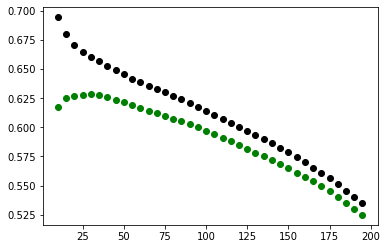

In [ ]:
plt.scatter(K, training, color='k')
plt.scatter(K, test, color='g')
plt.show()


The above graph and results show that the optimal k value for the 46A line is around 25.


In [ ]:
50/line_46A.shape[0]


0.0014435847095507564

In [ ]:
knn_46A = KNeighborsRegressor(n_neighbors=25)


In [ ]:
knn_46A.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=25)

In [ ]:
train_preds = knn_46A.predict(X_train)
train_preds


array([[4362.56],
       [3607.28],
       [4251.  ],
       ...,
       [4048.64],
       [4448.12],
       [4525.84]])

In [ ]:
test_preds = knn_46A.predict(X_test)


In [ ]:
X_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6928 entries, 116945 to 808371
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PLANNEDTIME_DEP  6928 non-null   float64
 1   humidity         6928 non-null   int64  
 2   wind_speed       6928 non-null   float64
 3   WEEKDAY          6928 non-null   int64  
 4   MONTH            6928 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 324.8 KB


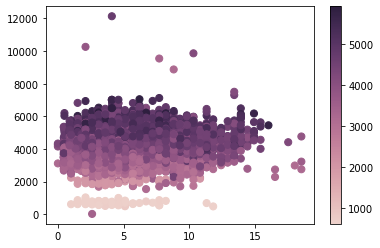

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
    X_test.iloc[:, 2], y_test.iloc[:, 0], c=test_preds, s=50, cmap=cmap)
f.colorbar(points)
plt.show()


## 3.2 Optimising the Random Forest model

Using the 46A line as this is the largest file, I will try to optimise the random forest regressor model

### 3.2.1 Pickle vs Joblib

In [23]:
line = '46A'
# dataframe containing only rows with current lineid
df_line = df_dir_1[df_dir_1['LINEID'] == line]

# randomly generate sequence based on dataframe index and set to be new index
df_line.set_index(np.random.permutation(df_line.index))
# sort the resulting random index
df_line.sort_index(inplace=True)

# drop unneeded columns
df_line.drop(columns=['LINEID'], inplace=True)

X = df_line.drop(columns=["TRIPTIME"], axis=1)
y = pd.DataFrame(df_line['TRIPTIME'])
# do test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

rfr = RandomForestRegressor(oob_score=True, random_state=1)
result = rfr.fit(X_train, y_train)

filenamej = '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/joblibfiles/testing/line_46A_model/dir1/joblib.joblib'
joblib.dump(result, open(filenamej, 'wb'))
filenamep = '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/joblibfiles/testing/line_46A_model/dir1/pickle.pkl'
pickle.dump(result, open(filenamep, 'wb'))

In [35]:
t1 = time()
filenamej = '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/joblibfiles/testing/line_46A_model/dir1/joblib.joblib'
model = joblib.load(filenamej) 
print(model.predict([[75,5.1,19800,1,1]]))
print(time() -t1)

[2055.11]
0.15904903411865234


In [36]:
t2 = time()
filenamep = '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/joblibfiles/testing/line_46A_model/dir1/pickle.pkl'
model = pickle.load(open(filenamep, 'rb')) 
print(model.predict([[75,5.1,19800,1,1]]))
print(time() -t2)

[2055.11]
0.0500178337097168


Pickle is much faster so we will use this as the file type.

### 3.2.2 Choosing the optimum test train split
To do this I will first get the rows with the highest number of lines from s4_feature_pairwise_interactions.ipynb and run them through the following algorithm where I will collect the test scores for each line while setting the test train split to different ratios. Finally I will plot the data to determine the optimum test train split.

In [ ]:
line = '46A'
# dataframe containing only rows with current lineid
df_line = df_dir_1[df_dir_1['LINEID'] == line]

# randomly generate sequence based on dataframe index and set to be new index
df_line.set_index(np.random.permutation(df_line.index))
# sort the resulting random index
df_line.sort_index(inplace=True)

# drop unneeded columns
df_line.drop(columns=['LINEID'], inplace=True)

X = df_line.drop(columns=["TRIPTIME"], axis=1)
y = pd.DataFrame(df_line['TRIPTIME'])

# find best test train split
i=0.1
score= []
I = []
while i <= 0.5:
    # do test train split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=i, random_state=1)

    rfr = RandomForestRegressor(oob_score=True, random_state=1)
    rfr.fit(X_train, y_train)
    test_score = rfr.score(X_test, y_test)

    score.append(test_score)
    I.append(i)

    i+=0.05

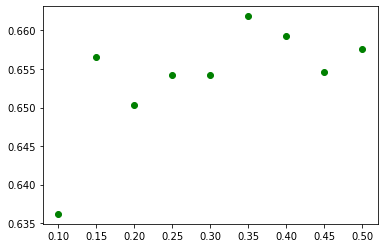

In [ ]:
plt.scatter(I, score, color='g')
plt.show()


The above graphs show that the model performs best on the test set when the test set has 35% of the data.

### 3.2.3 Finding the optimum max_depth and n_estimators
Setting the test set to 0.35, I will try to find the optimum max_depth and n_estimators.

In [ ]:
line = '46A'
# dataframe containing only rows with current lineid
df_line = df_dir_1[df_dir_1['LINEID'] == line]

# randomly generate sequence based on dataframe index and set to be new index
df_line.set_index(np.random.permutation(df_line.index))
# sort the resulting random index
df_line.sort_index(inplace=True)

# drop unneeded columns
df_line.drop(columns=['LINEID'], inplace=True)

X = df_line.drop(columns=["TRIPTIME"], axis=1)
y = pd.DataFrame(df_line['TRIPTIME'])

# do test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=1)

maxdepth = 50
estimators = 25
rfr = RandomForestRegressor(
    oob_score=True, random_state=1, max_depth=maxdepth, n_estimators=estimators)
result = rfr.fit(X_train, y_train)

# save the model to a joblib file
filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/joblibfiles/testing/line_46A_model/dir1/mdepth_{maxdepth}_est_{estimators}.joblib'
joblib.dump(result, open(filename, 'wb'))


In [ ]:
rfr_predictions_train = list(rfr.predict(X_train))
rfr_predictions_test = list(rfr.predict(X_test))

# choice of metrics from https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56 and
# https://towardsdatascience.com/random-forest-regression-5f605132d19d
train_mae = metrics.mean_absolute_error(y_train, rfr_predictions_train)
train_mape = metrics.mean_absolute_percentage_error(
    y_train, rfr_predictions_train)
train_rmse = math.sqrt(metrics.mean_squared_error(y_train,
                                                  rfr_predictions_train))
train_r2 = metrics.r2_score(y_train, rfr_predictions_train)

test_mae = metrics.mean_absolute_error(y_test, rfr_predictions_test)
test_mape = metrics.mean_absolute_percentage_error(
    y_test, rfr_predictions_test)
test_rmse = math.sqrt(metrics.mean_squared_error(y_test,
                                                 rfr_predictions_test))
test_r2 = metrics.r2_score(y_test, rfr_predictions_test)
with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/joblibfiles/testing/line_46A_model/dir1/mdepth_{maxdepth}_est_{estimators}_metrics.csv', 'w') as file:
    file.write(f'\nTrain metrics for line {line}:'
               f'\nMAE: {train_mae}' +
               f'\nMAPE: {train_mape}' +
               f'\nRMSE: {train_rmse}' +
               f'\nR2: {train_r2}' +
               f'\nTest metrics for line {line}:'
               f'\nMAE: {test_mae}' +
               f'\nMAPE: {test_mape}' +
               f'\nRMSE: {test_rmse}' +
               f'\nR2: {test_r2}')


In [ ]:
print(f"Max depth: {maxdepth}, n_estimators: {estimators}\n")
print("============Train metrics=============")
print("MAE:", train_mae)
print("MAPE:", train_mape)
print("RMSE:", train_rmse)
print("R2:", train_r2)

print("============Test metrics=============")
print("MAE:", test_mae)
print("MAPE:", test_mape)
print("RMSE:", test_rmse)
print("R2:", test_r2)


Max depth: 50, n_estimators: 25

============Train metrics=============
MAE: 145.60296248305212
MAPE: 0.034673059251634684
RMSE: 207.83463400258398
R2: 0.9431857544156798
============Test metrics=============
MAE: 379.9310031188257
MAPE: 0.10546923454464611
RMSE: 517.0230520777051
R2: 0.654134446617997


- Optimal max_depth = 50, n_estimators=25, file size 45.5MB

# 4 Direction 2
Remembering from <i>feature_pairwise_interactions.ipynb</i> the following:
* categorical_med_info_gain = ['weather_id']
* categorical_high_info_gain = ['HOUR','WEEKDAY','MONTH']

## 4.1 Test-train-split

In [78]:
df_dir_2 = pd.read_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/modelling_ready_dir2.csv')


In [79]:
df_dir_2.columns


Index(['LINEID', 'PLANNEDTIME_DEP', 'HOUR', 'humidity', 'wind_speed',
       'weather_id', 'TRIPTIME', 'WEEKDAY', 'MONTH', 'RUSHHOUR'],
      dtype='object')

Began model creation for Direction 2 by dropping poor performing features from the dataframe as these feature were dropped from direction 1's modelling.

In [80]:
df_dir_2 = df_dir_2.drop(
    columns=['HOUR', 'RUSHHOUR','weather_id'])

Perform test-train-split

In [81]:
return_func_2 = train_test_dicts(df_dir_2)


In [82]:
lines_dir = return_func_2[0]
X_train_dict = return_func_2[1]
y_train_dict = return_func_2[2]
X_test_dict = return_func_2[3]
y_test_dict = return_func_2[4]


## 4.2 Run the Algorithm

### 4.2.1 Random Forest

In [83]:
rf_model_dict = get_rfr_model_dict(2, lines_dir, X_train_dict, y_train_dict)


Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 118
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41A
Line 41B
Line 41C
Line 41D
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 46E
Line 47
Line 49
Line 51D
Line 51X
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 68X
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 7

In [84]:
rf_metric_list = get_rf_metric_lists(
    2, lines_dir, rf_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict)


Test MAE for line 1: 301.42589
Test R2 for line 1: 0.72385
Test MAE for line 102: 263.20988
Test R2 for line 102: 0.69897
Test MAE for line 104: 310.35711
Test R2 for line 104: 0.18028
Test MAE for line 11: 358.3776
Test R2 for line 11: 0.72958
Test MAE for line 111: 393.36695
Test R2 for line 111: 0.61061
Test MAE for line 114: 209.40528
Test R2 for line 114: 0.56947
Test MAE for line 116: 672.53474
Test R2 for line 116: 0.11512
Test MAE for line 118: 392.4034
Test R2 for line 118: 0.36158
Test MAE for line 120: 164.23466
Test R2 for line 120: 0.74742
Test MAE for line 122: 332.93838
Test R2 for line 122: 0.66925
Test MAE for line 123: 327.33558
Test R2 for line 123: 0.5643
Test MAE for line 13: 486.99082
Test R2 for line 13: 0.62872
Test MAE for line 130: 199.08639
Test R2 for line 130: 0.47107
Test MAE for line 14: 523.95611
Test R2 for line 14: 0.37323
Test MAE for line 140: 459.84135
Test R2 for line 140: 0.44983
Test MAE for line 142: 210.7848
Test R2 for line 142: 0.98169
Test M

In [85]:
rf_train_metric_list = rf_metric_list[0][0]
rf_test_metric_list = rf_metric_list[1][0]

In [86]:
print("RFR")
print_metrics(lines_dir, rf_train_metric_list, rf_test_metric_list)

RFR
============Train metrics=============
Mean MAE: 134.694
Mean MAPE: 0.03874
Mean RMSE: 192.81298
Mean R2: 0.91461
============Test metrics=============
Mean MAE: 346.44303
Mean MAPE: 0.10817
Mean RMSE: 477.14763
Mean R2: 0.14448


In [87]:
importance = pd.DataFrame(
    {'feature': X_train_dict['46A'].columns, 'importance': rf_model_dict['46A'].feature_importances_})
importance.sort_values('importance', ascending=False)


,feature,importance
0,PLANNEDTIME_DEP,0.649334
4,MONTH,0.108540
3,WEEKDAY,0.087846
2,wind_speed,0.079724
1,humidity,0.074556
